# **1. Import thư viện**

In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# **2. Chuẩn bị dữ liệu**

In [19]:
# Tải dữ liệu
df = pd.read_csv('ECommerce_Dataset_cleaned_model.csv')

In [20]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [21]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'

X = df.drop(columns=[target])
y = df[target]

In [22]:
# Xác định cột định lượng (numeric) và định tính (categorical)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [23]:
# ColumnTransformer: One-Hot Encoding + Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [24]:
# Xây dựng model
model = RandomForestClassifier(
    n_estimators=300,
    class_weight= 'balanced',
    random_state=42,
    n_jobs=-1
)

In [25]:
# Xây dựng Pipeline
clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

In [26]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# **4. Cross validation (10-fold)**

In [27]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')
y_proba_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

roc_auc_cv = roc_auc_score(y_train, y_proba_cv)
print(f"CV ROC-AUC: {roc_auc_cv:.5f}")
print("\nClassification Report (Cross-Validation on Train):")
print(classification_report(y_train, y_pred_cv))

CV ROC-AUC: 0.97962

Classification Report (Cross-Validation on Train):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3746
           1       0.94      0.76      0.84       758

    accuracy                           0.95      4504
   macro avg       0.94      0.87      0.91      4504
weighted avg       0.95      0.95      0.95      4504



# **5. Huấn luyện & dự đoán**

In [28]:
# Train model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CityTier',
                                                   'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'DevicePerTenure']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [29]:
# Dự đoán
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

# **6. Đánh giá mô hình**

In [30]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       936
           1       0.96      0.84      0.89       190

    accuracy                           0.97      1126
   macro avg       0.96      0.91      0.94      1126
weighted avg       0.97      0.97      0.97      1126



**Nhận xét:**

- Mô hình Random Forest đạt **accuracy = 97%**, cho thấy hiệu suất tổng thể rất tốt trên tập dữ liệu kiểm tra. Đối với lớp churn, mô hình đạt **precision = 0.96** và **recall = 0.84**, phản ánh khả năng phát hiện phần lớn khách hàng rời bỏ trong khi vẫn duy trì độ chính xác dự đoán ở mức rất cao.

- Chỉ số F1-score của lớp **churn = 0.89** cho thấy sự cân bằng hợp lý giữa precision và recall trong bối cảnh dữ liệu mất cân bằng. Các giá trị **macro F1 = 0.94** và **weighted F1 = 0.97** không có dấu hiệu lệch bất thường, cho thấy mô hình không bị thiên lệch quá mức về lớp đa số.

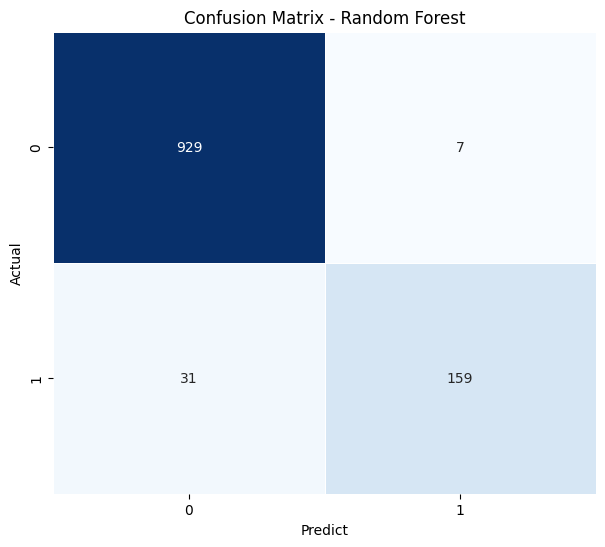

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

**Nhận xét:**

- Dự đoán đúng **159 khách hàng** có khả năng rời bỏ, giúp doanh nghiệp triển khai các chiến lược giữ chân một cách chính xác và hiệu quả.

- Nhận diện chính xác **929 khách hàng** trung thành, từ đó tránh việc tiếp cận không cần thiết và tối ưu chi phí vận hành.

- **Tỷ lệ sai sót:**
  - Lỗi nghiêm trọng nhất (không phát hiện khách hàng Churn): **31 trường hợp**.

  - Lỗi ít nghiêm trọng hơn (dự đoán nhầm khách hàng trung thành là Churn): **7 trường hợp**.


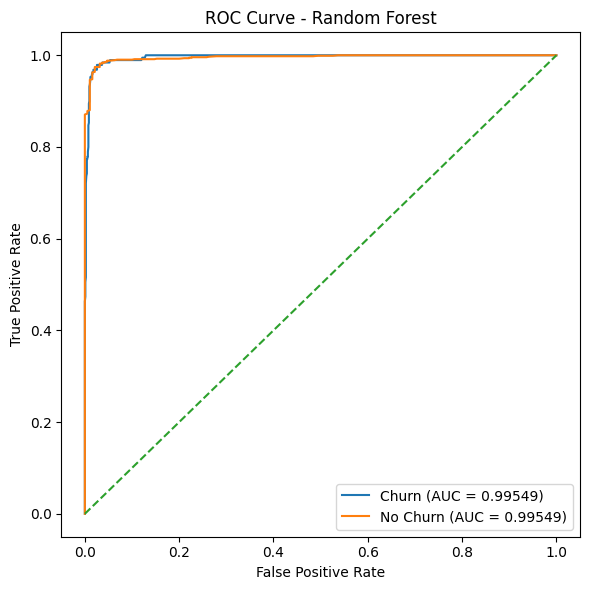

In [32]:
# vẽ ROC Curve

# Lớp churn = 1
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba[:, 1])
auc_1 = auc(fpr_1, tpr_1)

# Lớp churn = 0
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_proba[:, 0])
auc_0 = auc(fpr_0, tpr_0)

plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.5f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:**

- **AUC = 0.99549** cho thấy mô hình đạt năng lực phân tách rất cao giữa hai lớp Churn và không Churn, phản ánh chất lượng dự đoán gần mức tối ưu.

- Đường ROC tiến sát vùng góc trên bên trái chứng tỏ mô hình nhận diện hiệu quả các trường hợp Churn, đồng thời kiểm soát tốt tỷ lệ dự đoán sai đối với lớp không Churn.
